# Моделирование: XGBoost, LightGBM и CatBoost для задачи buy/sell

В этом ноутбуке мы:

- Подготовим и загрузим датасет с признаками и целевой переменной `y_bs` (buy=1 / sell=0), сформированной в `feature_engineering_pipeline.ipynb`
- Настроим разбиение по времени (train/valid/test) и кросс-валидацию walk-forward (TimeSeriesSplit)
- Обучим три модели: XGBoost, LightGBM и CatBoost, с учётом дисбаланса классов и ранней остановкой
- Посчитаем метрики качества (F1, Balanced Accuracy, logloss), сохраним артефакты в `06_reports`
- Сформируем сводную таблицу и визуализации для сравнения моделей

Все шаги сопровождаются объяснениями и выполняются в отдельных блоках кода.



## 1. Импорт библиотек и настройка окружения

В этом блоке:
- Импортируем необходимые библиотеки и функции из проекта
- Зададим пути к данным и артефактам
- Создадим директории для сохранения результатов (`06_reports`), если их нет
- Зафиксируем случайность для воспроизводимости


In [1]:
import os
from pathlib import Path
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Пути проекта (определяем корень проекта над ноутбуком)

def _find_project_root(start: Path) -> Path:
    base = start if start.is_dir() else start.parent
    for candidate in [base] + list(base.parents):
        if (candidate / "03_src").exists() and (candidate / "04_configs").exists():
            return candidate
    raise RuntimeError(
        "Не удалось найти корень проекта. Убедитесь, что существуют папки '03_src' и '04_configs' выше по дереву."
    )

try:
    _here = Path(__file__).resolve()
except NameError:
    _here = Path.cwd().resolve()

PROJECT_ROOT = _find_project_root(_here)
DATA_PROCESSED = PROJECT_ROOT / "01_data/processed"
REPORTS_DIR = PROJECT_ROOT / "06_reports"
CONFIG_SPLITS = PROJECT_ROOT / "04_configs/splits.yml"

# Создаём директорию для отчётов
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Фиксируем случайность
np.random.seed(42)

# Удобства отрисовки
plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Добавим путь к исходникам, чтобы импортировать модули проекта
import sys
SRC_DIR = PROJECT_ROOT / "03_src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from models import run_modeling_pipeline # type: ignore[reportMissingImports]


In [2]:
from datetime import datetime

# Имя подпапки запуска: 06_reports/exp_####_YYYYMMDD_HHMMSS (#### — из models.yml → experiment.current_id)
try:
    with open(PROJECT_ROOT / "04_configs" / "models.yml", "r", encoding="utf-8") as f:
        _models_cfg_for_run = yaml.safe_load(f) or {}
        _exp_id_cfg = ((_models_cfg_for_run.get("experiment") or {}).get("current_id") or "exp_0000")
except Exception:
    _exp_id_cfg = "exp_0000"

prefix = str(_exp_id_cfg).lower()
RUN_DIR = REPORTS_DIR / f"{prefix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Переназначаем REPORTS_DIR на подпапку запуска, чтобы все сохранения шли туда
REPORTS_DIR = RUN_DIR
print(f"Каталог результатов текущего запуска: {REPORTS_DIR}")


Каталог результатов текущего запуска: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531


## 2. Данные для моделирования

В этом блоке:
- Проверим наличие файла с признаками и целевой переменной
- Убедимся, что целевая переменная `y_bs` присутствует (добавляется в feature engineering пайплайне)
- Выполним базовый sanity-check


In [3]:
# Имя файла фич: читаем из feature_engineering.yml (dataset.active + output_pattern)
cfg_path = PROJECT_ROOT / "04_configs" / "feature_engineering.yml"
try:
    with open(cfg_path, "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f) or {}
except FileNotFoundError:
    raise FileNotFoundError(f"Не найден конфиг Feature Engineering: {cfg_path}. Проверьте путь '04_configs/feature_engineering.yml'.")

ps = (cfg.get("pipeline_settings") or {})
feature_set = ps.get("feature_set")
if not feature_set:
    raise KeyError("В конфиге отсутствует 'pipeline_settings.feature_set'. Укажите активный набор признаков (например, 'fset-1').")

fsets = (cfg.get("feature_sets") or {})
if feature_set not in fsets:
    raise KeyError(f"Указанный набор признаков '{feature_set}' отсутствует в секции 'feature_sets' файла конфига.")

ds = (cfg.get("dataset") or {})
active = ds.get("active")
items = (ds.get("items") or {})
symbol = (items.get(active) or {}).get("symbol", "ASSET")
symbol_lower = str(symbol).lower()
output_dir = ps.get("output_dir", "01_data/processed")
output_pattern = ps.get("output_pattern", "{symbol_lower}_{feature_set}_features.parquet")

FEATURES_FILE = PROJECT_ROOT / output_dir / output_pattern.format(
    symbol_lower=symbol_lower,
    feature_set=feature_set,
)

if not FEATURES_FILE.exists():
    raise FileNotFoundError(f"Не найден файл фич: {FEATURES_FILE}. Сначала запустите пайплайн feature engineering.")

# Загружаем и быстрый sanity-check
df = pd.read_parquet(FEATURES_FILE)
print("Форма датасета:", df.shape)
print("Индекс отсортирован по времени:", isinstance(df.index, pd.DatetimeIndex) and df.index.is_monotonic_increasing)

# Строгая проверка наличия целевой переменной y_bs
if "y_bs" not in df.columns:
    raise ValueError("В датасете отсутствует целевая переменная 'y_bs'. Добавьте её на этапе feature engineering.")

# Быстрые проверки признаков
print("Есть ли NaN в признаках:", df.filter(regex=r"^(f_|close)$").isna().any().any())
df[["y_bs"]].head()


Форма датасета: (88497, 22)
Индекс отсортирован по времени: True
Есть ли NaN в признаках: False


,y_bs
Time,
2010-01-05 18:00:00+00:00,1
2010-01-05 19:00:00+00:00,0
2010-01-05 20:00:00+00:00,1
2010-01-05 21:00:00+00:00,0
2010-01-05 22:00:00+00:00,0


## 3. Настройки разбиения по времени и кросс-валидации

В этом блоке:
- Загрузим конфигурацию `04_configs/splits.yml`
- Отобразим текущие параметры (доли/даты разрезов, параметры `TimeSeriesSplit`)
- Сохраним конфигурацию в `06_reports` как артефакт эксперимента


In [4]:
with open(CONFIG_SPLITS, "r", encoding="utf-8") as f:
    splits_cfg = yaml.safe_load(f)

print("Конфигурация разбиения по времени:")
print(json.dumps(splits_cfg, ensure_ascii=False, indent=2))

# Сохраняем копию конфигурации для воспроизводимости эксперимента
backup_cfg_path = REPORTS_DIR / "splits_used_in_experiment.yml"
with open(backup_cfg_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(splits_cfg, f, allow_unicode=True)
print(f"Конфигурация разбиения сохранена: {backup_cfg_path}")


Конфигурация разбиения по времени:
{
  "version": 1,
  "description": "Временные разрезы для обучения/валидации/теста и фолды TimeSeriesSplit",
  "splits": {
    "method": "ratios",
    "ratios": {
      "train": 0.7,
      "valid": 0.15,
      "test": 0.15
    },
    "dates": {
      "train_end": null,
      "valid_end": null,
      "test_start": null
    }
  },
  "time_series_cv": {
    "n_splits": 5,
    "max_train_size": null,
    "test_size": null,
    "gap": 5
  },
  "artifacts": {
    "save_cv_indices": true,
    "save_split_dates": true
  }
}
Конфигурация разбиения сохранена: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\splits_used_in_experiment.yml


## 4. Обучение моделей и сбор метрик

В этом блоке:
- Запустим пайплайн `run_modeling_pipeline` с размеченными фичами
- Получим результаты по каждому фолду и усреднённые метрики по CV
- Оценим финальные метрики на отложенной тестовой выборке
- Сохраним отчёт `modeling_results.json` и обученные модели в `06_reports`


In [5]:
# Запуск моделирования (можно ограничить моделями через models_to_run=["xgboost", ...])
results = run_modeling_pipeline(
    features_path=str(FEATURES_FILE.relative_to(PROJECT_ROOT)),
    config_splits_path=str(CONFIG_SPLITS.relative_to(PROJECT_ROOT)),
    save_dir=str(REPORTS_DIR.relative_to(PROJECT_ROOT)),
)

# Сохраняем ещё раз сводные результаты (хотя функция уже сохранила)
results_path = REPORTS_DIR / "modeling_results.json"
with open(results_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"Итоговый отчёт с метриками сохранён: {results_path}")
list(results.keys())


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.693397
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.691182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.692993
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.693024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.692289
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's binary_logloss: 0.116181
Итоговый отчёт с метриками сохранён: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\m

['xgboost', 'lightgbm', 'catboost']

## 5. Сводная таблица метрик по моделям

В этом блоке подготовим компактную сводку метрик:
- Средние по CV (F1, Balanced Accuracy, Accuracy, logloss, ROC-AUC)
- Метрики на тестовой выборке

Также сохраним таблицу в `06_reports/metrics_summary.csv`.


In [6]:
# Преобразуем результаты в сводную таблицу
rows = []
for model_name, payload in results.items():
    cv_avg = payload.get("cv_avg", {})
    test_metrics = payload.get("test_metrics", {})
    row = {
        "model": model_name,
        "cv_f1": cv_avg.get("f1"),
        "cv_balanced_accuracy": cv_avg.get("balanced_accuracy"),
        "cv_accuracy": cv_avg.get("accuracy"),
        "cv_logloss": cv_avg.get("logloss"),
        "cv_roc_auc": cv_avg.get("roc_auc"),
        "test_f1": test_metrics.get("f1"),
        "test_balanced_accuracy": test_metrics.get("balanced_accuracy"),
        "test_accuracy": test_metrics.get("accuracy"),
        "test_logloss": test_metrics.get("logloss"),
        "test_roc_auc": test_metrics.get("roc_auc"),
    }
    rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(by=["test_f1"], ascending=False)
summary_df


,model,cv_f1,cv_balanced_accuracy,cv_accuracy,cv_logloss,cv_roc_auc,test_f1,test_balanced_accuracy,test_accuracy,test_logloss,test_roc_auc
2,catboost,0.542365,0.506865,0.506780,0.692716,0.512158,0.522375,0.508026,0.507984,0.730540,0.513867
1,lightgbm,0.338435,0.509590,0.510482,0.692577,0.518460,0.519302,0.514176,0.514161,0.803883,0.518660
0,xgboost,0.483088,0.510471,0.510801,0.692576,0.516489,0.516449,0.507333,0.507306,0.737457,0.513029


In [7]:
# Сохраняем сводную таблицу
metrics_csv = REPORTS_DIR / "metrics_summary.csv"
summary_df.to_csv(metrics_csv, index=False)
print(f"Сводная таблица метрик сохранена: {metrics_csv}")


Сводная таблица метрик сохранена: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\metrics_summary.csv


## 6. Визуализация: сравнение моделей по метрикам

В этом блоке построим сравнительные графики:
- Столбчатые диаграммы для CV и Test F1_macro
- При необходимости — диаграммы для Balanced Accuracy и mlogloss

Графики также сохраним в `06_reports`.


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_8188\3923255236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


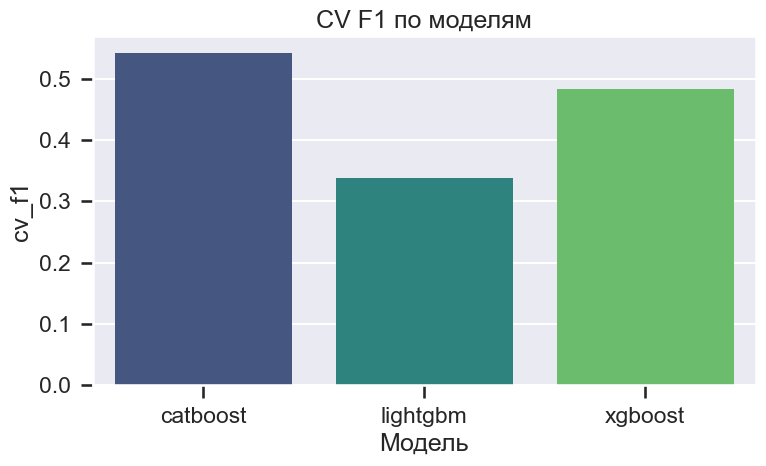

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\cv_f1.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_8188\3923255236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


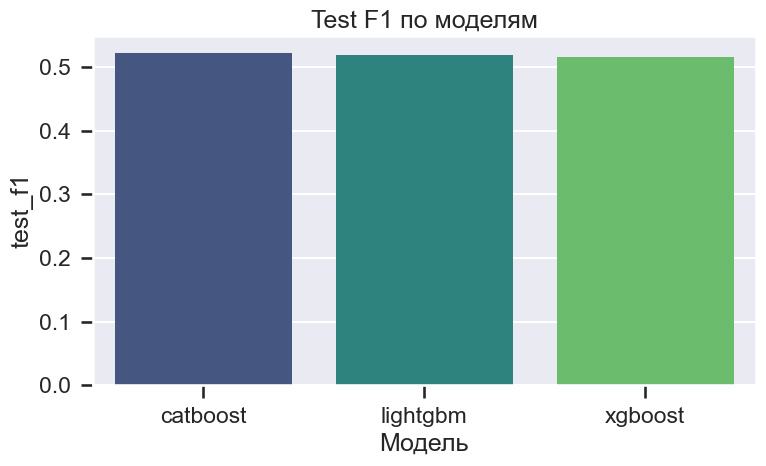

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\test_f1.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_8188\3923255236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


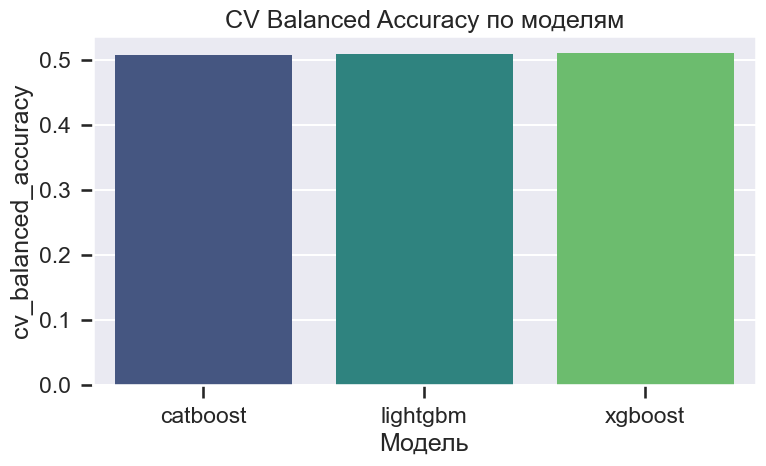

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\cv_bal_acc.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_8188\3923255236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


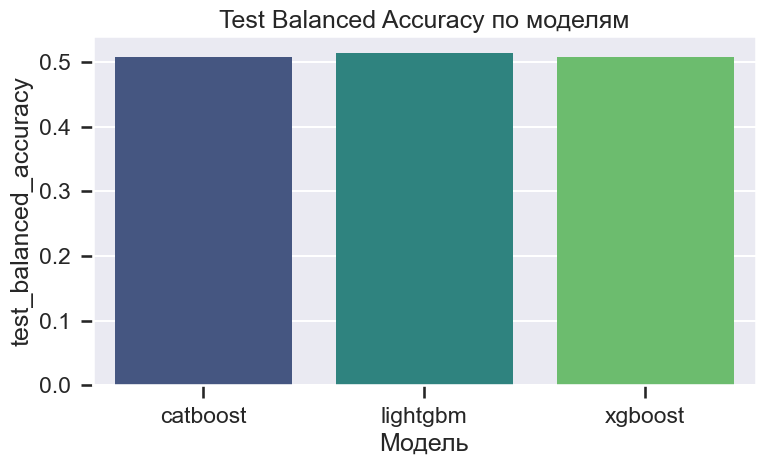

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\test_bal_acc.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_8188\3923255236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


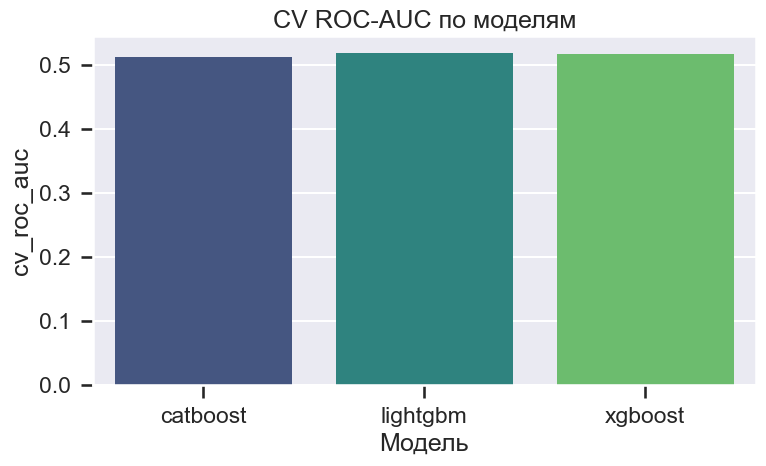

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\cv_roc_auc.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_8188\3923255236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


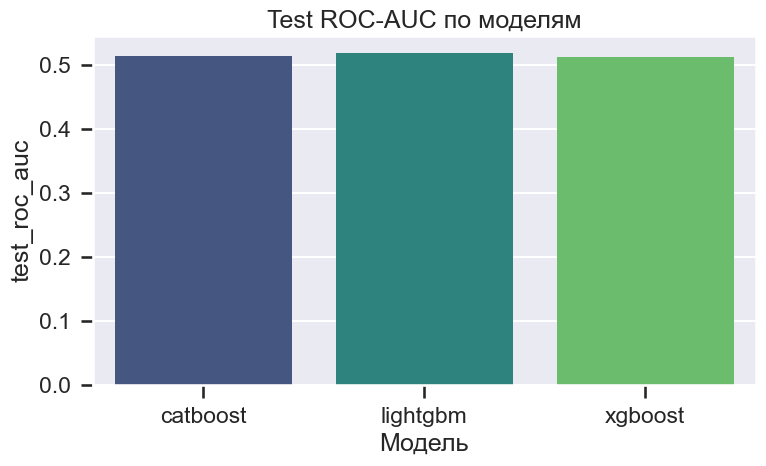

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\test_roc_auc.png


In [8]:
def plot_bar(df: pd.DataFrame, value_col: str, title: str, fname: str):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x="model", y=value_col, palette="viridis")
    plt.title(title)
    plt.xlabel("Модель")
    plt.ylabel(value_col)
    plt.tight_layout()
    out_path = REPORTS_DIR / fname
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Сохранено: {out_path}")

plot_bar(summary_df, "cv_f1", "CV F1 по моделям", "cv_f1.png")
plot_bar(summary_df, "test_f1", "Test F1 по моделям", "test_f1.png")

# Дополнительно (при необходимости):
plot_bar(summary_df, "cv_balanced_accuracy", "CV Balanced Accuracy по моделям", "cv_bal_acc.png")
plot_bar(summary_df, "test_balanced_accuracy", "Test Balanced Accuracy по моделям", "test_bal_acc.png")
plot_bar(summary_df, "cv_roc_auc", "CV ROC-AUC по моделям", "cv_roc_auc.png")
plot_bar(summary_df, "test_roc_auc", "Test ROC-AUC по моделям", "test_roc_auc.png")


## 7. Детальный разбор ошибок (Confusion Matrix)

Для каждой модели визуализируем матрицу ошибок по тестовой выборке, чтобы понять, где модель чаще всего ошибается (перепутывает классы).


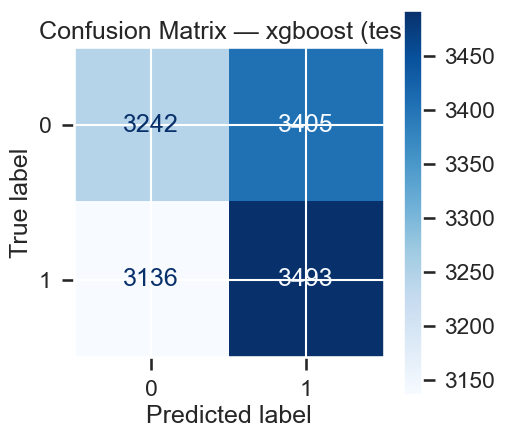

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\cm_xgboost.png


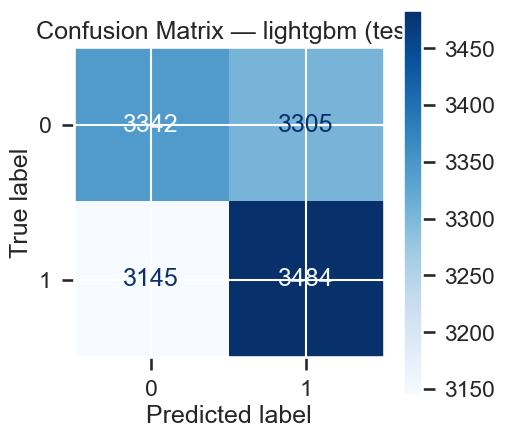

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\cm_lightgbm.png


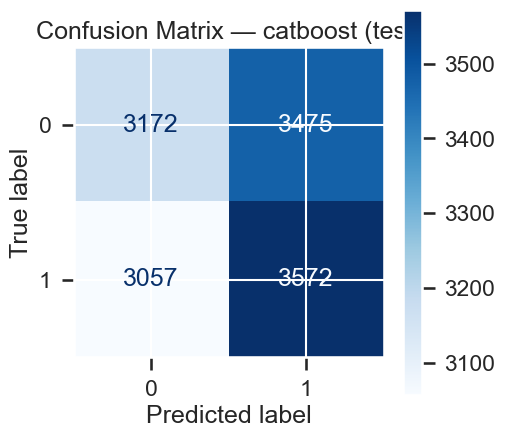

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\cm_catboost.png


In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

for model_name, payload in results.items():
    details = payload.get("test_details", {})
    cm = np.array(details.get("confusion_matrix"))
    if cm.size == 0:
        continue
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {model_name} (test)")
    out_path = REPORTS_DIR / f"cm_{model_name}.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Сохранено: {out_path}")


## 8. Сохранение окружения эксперимента и резюме

- Сохраним версии ключевых пакетов и случайное зерно
- Сформируем краткое резюме результатов (лучшая модель по F1_macro на тесте)
- Сохраним артефакты в `06_reports`


In [10]:
env_info = {
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "seed": 42,
}

best_row = summary_df.sort_values(by=["test_f1"], ascending=False).head(1)
resume = {
    "best_model": best_row["model"].iloc[0] if not best_row.empty else None,
    "best_test_f1": float(best_row["test_f1"].iloc[0]) if not best_row.empty else None,
}

with open(REPORTS_DIR / "env_and_resume.json", "w", encoding="utf-8") as f:
    json.dump({"env": env_info, "resume": resume}, f, ensure_ascii=False, indent=2)

print("Сохранено:", REPORTS_DIR / "env_and_resume.json")
resume


Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\env_and_resume.json


{'best_model': 'catboost', 'best_test_f1': 0.5223749634396022}

In [11]:
# 9. Автологирование эксперимента в CSV (для переноса в Notion)
from pathlib import Path
from datetime import datetime, timezone
import yaml
import json
import pandas as pd
import numpy as np

EXPERIMENTS_CSV = (PROJECT_ROOT / "06_reports" / "experiments.csv")

PRIMARY_DEFAULT = None
CURRENT_EXP_ID = None
try:
    with open(PROJECT_ROOT / "04_configs" / "models.yml", "r", encoding="utf-8") as f:
        _models_cfg = yaml.safe_load(f) or {}
        PRIMARY_DEFAULT = _models_cfg.get("metrics", {}).get("primary")
        CURRENT_EXP_ID = (_models_cfg.get("experiment") or {}).get("current_id")
except Exception:
    PRIMARY_DEFAULT = None
    CURRENT_EXP_ID = None


def _infer_asset_tf(fe_cfg: dict) -> str:
    # 1) Пробуем из dataset.items[active]: symbol + timeframe
    try:
        ds = (fe_cfg.get("dataset") or {})
        active_key = ds.get("active")
        item = (ds.get("items") or {}).get(active_key) or {}
        symbol = item.get("symbol")
        tf = item.get("timeframe")
        if symbol and tf:
            return f"{str(symbol).upper()}/{str(tf).upper()}"
    except Exception:
        pass
    # 2) Фоллбек: парсинг из dataset.active (eurusd_h1_...) → EURUSD/H1
    try:
        active_key = ((fe_cfg.get("dataset") or {}).get("active") or "")
        parts = str(active_key).split("_")
        if len(parts) >= 2:
            asset = parts[0]
            tf = parts[1]
            if asset and tf:
                return f"{asset.upper()}/{tf.upper()}"
    except Exception:
        pass
    # 3) Фоллбек: исходный метод по имени файла
    try:
        input_file = fe_cfg.get("pipeline_settings", {}).get("input_file", "")
        base = Path(input_file).name
        parts = base.split("_")
        if len(parts) >= 3:
            asset = parts[0]
            tf = parts[2]
            return f"{asset}/{tf}"
    except Exception:
        pass
    return "UNKNOWN/TF"


def _infer_ids(fe_cfg: dict) -> tuple[str, str, str]:
    # Dataset — из feature_engineering.yml → dataset.active
    dataset_id = str(((fe_cfg.get("dataset") or {}).get("active")) or "unknown_dataset")

    # Target — из feature_definitions.y_bs.params.horizon + method
    fd = (fe_cfg.get("feature_definitions") or {})
    y_bs = (fd.get("y_bs") or {})
    params = (y_bs.get("params") or {})
    horizon = params.get("horizon")
    method = (y_bs.get("method") or "binary_target")
    # Преобразование: horizon=5 → h5; method=binary_target → binary
    h_part = f"h{int(horizon)}" if isinstance(horizon, (int, float)) else "h?"
    m_part = "binary" if "binary" in str(method).lower() else str(method).lower()
    target_id = f"target_{h_part}_{m_part}"

    # Feature set — из pipeline_settings.feature_set
    ps = (fe_cfg.get("pipeline_settings") or {})
    fset_id = str(ps.get("feature_set") or "fset-?")

    return dataset_id, target_id, fset_id


def _compute_class_shares(y_true: np.ndarray) -> tuple[float, float]:
    total = float(len(y_true)) if len(y_true) else 1.0
    up = float((y_true == 1).sum()) / total
    down = float((y_true == 0).sum()) / total
    return up, down


def _round3(x: float | None) -> float | None:
    if x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x))):
        return None
    return float(np.round(x, 3))


def append_experiment_record(
    *,
    experiment_id: str,
    results: dict,
    summary_df: pd.DataFrame,
    splits_cfg: dict,
    features_cfg: dict,
    run_dir: Path,
    primary_metric: str | None = None,
    seed: int = 42,
    model_name: str | None = None,
    params_str: str | None = None,
):
    # Выбор лучшей модели по primary_metric (если модель не указана явно)
    metric = primary_metric or PRIMARY_DEFAULT or "f1"
    df = summary_df.copy()
    # На тесте используем test_<metric>, иначе cv_<metric>
    test_col = f"test_{metric}"
    cv_col = f"cv_{metric}"
    sort_col = test_col if test_col in df.columns else (cv_col if cv_col in df.columns else None)
    if sort_col is not None:
        df = df.sort_values(by=[sort_col], ascending=False)
    chosen_model = model_name or (df["model"].iloc[0] if not df.empty else None)

    # Берём метрики выбранной модели с теста (fallback на CV)
    metrics_map = {m: None for m in [
        "accuracy", "f1", "precision", "recall",
        "balanced_accuracy", "roc_auc"
    ]}

    # Источник метрик — структура в results
    if chosen_model and chosen_model in results:
        payload = results[chosen_model]
        test_metrics = payload.get("test_metrics", {})
        cv_avg = payload.get("cv_avg", {})
        # В нашем пайплайне есть accuracy, balanced_accuracy, f1, logloss, roc_auc
        metrics_map["accuracy"] = test_metrics.get("accuracy", cv_avg.get("accuracy"))
        metrics_map["f1"] = test_metrics.get("f1", cv_avg.get("f1"))
        metrics_map["balanced_accuracy"] = test_metrics.get("balanced_accuracy", cv_avg.get("balanced_accuracy"))
        metrics_map["roc_auc"] = test_metrics.get("roc_auc", cv_avg.get("roc_auc"))
        # Остальные могут отсутствовать — оставим None

        # Посчитаем precision/recall/mcc/roc/pr при наличии отчёта
        details = payload.get("test_details", {})
        cls_report = details.get("classification_report") or {}
        binary = cls_report.get("weighted avg") or {}
        if "precision" in binary:
            metrics_map["precision"] = binary.get("precision")
        if "recall" in binary:
            metrics_map["recall"] = binary.get("recall")
        # MCC и PR-AUC в текущем пайплайне не считаются — оставим None

        # Для долей классов (binary): возьмём поддержку из отчёта или из confusion matrix
        up_sh, down_sh = None, None
        labels = ["0", "1"]
        try:
            supports = [cls_report.get(lbl, {}).get("support") for lbl in labels]
            if all(isinstance(s, (int, float)) for s in supports):
                total = float(sum(supports)) if sum(supports) else 1.0
                down_sh = float(supports[0]) / total
                up_sh = float(supports[1]) / total
        except Exception:
            pass
        if up_sh is None or down_sh is None:
            cm = np.array(details.get("confusion_matrix") or [])
            if cm.size > 0:
                supports = cm.sum(axis=1)
                total = float(supports.sum()) if supports.sum() else 1.0
                down_sh = float(supports[0]) / total
                up_sh = float(supports[1]) / total
    else:
        up_sh = down_sh = None

    # Преобразуем к нужной точности
    acc = _round3(metrics_map["accuracy"]) if metrics_map["accuracy"] is not None else None
    f1 = _round3(metrics_map["f1"]) if metrics_map["f1"] is not None else None
    precision = _round3(metrics_map["precision"]) if metrics_map["precision"] is not None else None
    recall = _round3(metrics_map["recall"]) if metrics_map["recall"] is not None else None
    bal_acc = _round3(metrics_map["balanced_accuracy"]) if metrics_map["balanced_accuracy"] is not None else None
    mcc = None
    roc_auc = _round3(metrics_map["roc_auc"]) if metrics_map["roc_auc"] is not None else None
    pr_auc = None

    # Asset/TF и связи
    asset_tf = _infer_asset_tf(features_cfg)
    dataset_id, target_id, fset_id = _infer_ids(features_cfg)

    # Primary
    primary_metric = metric
    primary_value = None
    if metric in {"f1", "balanced_accuracy", "accuracy", "roc_auc"}:
        primary_value = {"f1": f1, "balanced_accuracy": bal_acc, "accuracy": acc, "roc_auc": roc_auc}[metric]

    # Model/Params
    model_for_row = chosen_model or ""
    params_for_row = params_str or ""

    # Date — UTC timestamp окончания (берем текущее время как момент фиксации)
    now_utc = datetime.now(timezone.utc).isoformat(timespec="seconds")

    # Соберём запись и добавим в CSV
    columns = [
        "ID","Date","Asset/TF","Dataset","Target","Feature set","Model","Params",
        "Validation","Seed","Acc","F1","Precision","Recall","BalancedAcc",
        "ROC-AUC","Up %","Down %","Primary metric","Primary value",
    ]

    # Validation кодируем компактно
    val_scheme = splits_cfg.get("time_series_cv", {})
    n_splits = val_scheme.get("n_splits")
    gap = val_scheme.get("gap")
    validation_str = f"tscv_k={n_splits}" if n_splits else "tscv"
    if gap:
        validation_str += f"_gap={gap}"

    row = [
        experiment_id,
        now_utc,
        asset_tf,
        dataset_id,
        target_id,
        fset_id,
        model_for_row,
        params_for_row,
        validation_str,
        int(seed) if seed is not None else None,
        acc,
        f1,
        precision,
        recall,
        bal_acc,
        roc_auc,
        _round3(up_sh) if up_sh is not None else None,
        _round3(down_sh) if down_sh is not None else None,
        primary_metric,
        _round3(primary_value) if primary_value is not None else None,
    ]

    EXPERIMENTS_CSV.parent.mkdir(parents=True, exist_ok=True)
    if EXPERIMENTS_CSV.exists():
        df_csv = pd.read_csv(EXPERIMENTS_CSV)
        if set(df_csv.columns) != set(columns):
            # Переписываем с корректными колонками, сохраняя старые по совпадающим
            df_csv = df_csv.reindex(columns=columns)
        df_csv = pd.concat([df_csv, pd.DataFrame([row], columns=columns)], ignore_index=True)
    else:
        df_csv = pd.DataFrame([row], columns=columns)
    df_csv.to_csv(EXPERIMENTS_CSV, index=False)
    print(f"Запись эксперимента добавлена: {EXPERIMENTS_CSV}")


# Подготовка данных для автозаполнения и вызов
with open(PROJECT_ROOT / "04_configs" / "feature_engineering.yml", "r", encoding="utf-8") as f:
    fe_cfg = yaml.safe_load(f) or {}

with open(REPORTS_DIR / "modeling_results.json", "r", encoding="utf-8") as f:
    results_json = json.load(f)

append_experiment_record(
    experiment_id=str(CURRENT_EXP_ID or "exp_0000").upper(),
    results=results_json,
    summary_df=summary_df,
    splits_cfg=splits_cfg,
    features_cfg=fe_cfg,
    run_dir=REPORTS_DIR,
    primary_metric=None,  # если None, берём из models.yml
    seed=42,
    model_name=None,
    params_str=None,
)


Запись эксперимента добавлена: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\experiments.csv
